## Plot Benchmark Data
This python notebook uses `matplotlib` and `pandas`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_json('benchmark-hdfs-all-branches.json',orient='records')

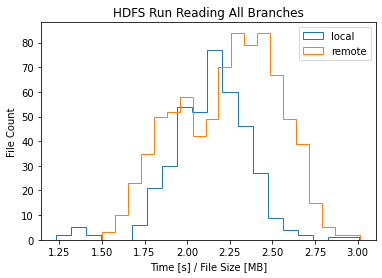

In [27]:
plt.hist(df[df['local']]['time']/df[df['local']]['size']*10**6, histtype='step', label = 'local', bins=20)
plt.hist(df[df['local']==False]['time']/df[df['local']==False]['size']*10**6, histtype='step',label='remote',bins=20)
plt.xlabel('Time [s] / File Size [MB]')
plt.ylabel('File Count')
plt.title('HDFS Run Reading All Branches')
plt.legend()